###**Librerias y dependencias**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
from scipy.io.wavfile import read
from IPython.display import Audio
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cosine
from scipy.optimize import brentq
from scipy.stats import gaussian_kde
from sklearn.metrics import accuracy_score, confusion_matrix

##**Introducción**

En este proyecto se desarrollará una metodología para la **verificación automática de identidad a partir de voz**, empleando representaciones vectoriales construidas mediante análisis de energía en bancos de filtros. Este trabajo corresponde al proyecto final del curso *Tratamiento de Señales I* de la Universidad de Antioquia.

El objetivo principal es implementar un sistema capaz de distinguir si una grabación de voz corresponde o no al estudiante (uno de los autores del sistema), basándose en características acústicas extraídas del audio. Para ello, se utilizarán técnicas de análisis de señales, cálculo de potencias por bandas de frecuencia y comparación de vectores representativos mediante métricas de similitud.

###Objetivos específicos

- Construir una base de datos con grabaciones de voz propias y de otras personas (impostores).
- Generar representaciones vectoriales a partir de energía por bandas utilizando bancos de filtros.
- Comparar dichas representaciones mediante una métrica de similitud.
- Determinar un umbral que permita aceptar o rechazar una identidad con base en un criterio estadístico.
- Evaluar el desempeño del sistema utilizando histogramas de distancias y pruebas estadísticas.

Este documento contendrá el desarrollo paso a paso de cada etapa del proyecto, incluyendo el código, justificaciones y resultados obtenidos.


##**Construcción de la base de datos de referencia**

Para la construcción de la base de datos, se recolectaron audios de 20 personas distintas (10 hombres y 10 mujeres), todos dentro de un mismo rango de edad, controlando una desviación máxima de ±2 años respecto a la edad de uno de los autores del proyecto. También se realizé la toma de 11 monólogos (voz de uno de los autores del sistema) en diferentes ambientes.

### **Base de datos Impostores**

El proceso consistió en solicitar a conocidos el envío de **audios de 30 segundos** a través de la aplicación **WhatsApp**, en los que cada persona hablara libremente sobre el tema que deseara (habla espontánea), y que envieran su edad para realizar la prueba de paridad de edad.

Una vez recibidos, los audios fueron descargados y convertidos a el formato `.wav`  para posteriormente ser almacenados de forma ordenada en una carpeta, utilizando el siguiente formato de nombre: `X_edad_audioy.wav`, donde:

- `X` representa el género del hablante (`M` para hombres, `W` para mujeres),
- `edad` corresponde a la edad de la persona en años,
- `y` es un número identificador del audio dentro del conjunto.

Este esquema de nomenclatura facilita la organización de los datos y permite realizar análisis posteriores por género y edad, así como verificar que los grupos están pareados según los requisitos del proyecto.


Este conjunto conforma el grupo de **impostores**, es decir, personas diferentes al autor del sistema, y será utilizado más adelante para comparar sus características vocales frente a las del conjunto de test.

In [ ]:
carpeta_audios_impostores = '/content/drive/MyDrive/Proyecto de reconocimiento de voz/Base de datos/Impostores' #Cargamos ruta de carpeta de impostores

audios_impostores = {} #Diccionario donde se guardaran los audios de los impostores
for archivo in os.listdir(carpeta_audios_impostores):
    ruta_completa = os.path.join(carpeta_audios_impostores, archivo) #Obtenemos la ruta completa del audio
    fs, audio = read(ruta_completa) #leemos el audio, fs = frecuencia de muestreo y audio = audio correspondiente
    if len(audio.shape) > 1: #Pasamos de estéreo a mono de ser necesario
        audio = audio.mean(axis=1)
    if np.max(np.abs(audio)) > 0: #Normalizamos audio
      audio = audio / np.max(np.abs(audio))
    audio = audio.astype(np.float32)
    fs_target = 16000
    audio = librosa.resample(audio, orig_sr=fs, target_sr=fs_target) #Resampleamos a 16KHz
    fs = fs_target
    audios_impostores[archivo] = {'fs': fs, 'audio': audio} #Vamos llenando el diccionario

NameError: name 'os' is not defined

####**Breve verificación de carga**

In [ ]:
print(f"Total de audios cargados: {len(audios_impostores)}")

nombre_archivo = 'M_20_audio01.wav'

audio_array = audios_impostores[nombre_archivo]['audio']
fs = audios_impostores[nombre_archivo]['fs']
Audio(audio_array, rate=fs)

###**Base de datos de test (voz propia)**

Para conformar el conjunto de test se grabaron un total de **11 monólogos con la voz de uno de los autores del sistema**. Estas grabaciones tienen una duración aproximada de 20 segundos cada una y fueron realizadas en diferentes entornos acústicos con el fin de simular condiciones reales y evaluar la robustez del sistema de verificación de identidad.

Una de las grabaciones fue realizada en un ambiente controlado, sin ruido de fondo, y fue designada como el **audio de referencia**. Las otras diez grabaciones se realizaron en **ambientes cotidianos con distintos niveles de ruido y reverberación**, los cuales fueron:

- Baño con eco  
- Fiesta  
- Universidad  
- Cancha de fútbol  
- Calle  
- Balcón con ruido  
- Reunión familiar  
- Habitación con ventilador  

Los audios fueron almacenados en una carpeta utilizando el siguiente formato de nombre: `audioy_ambiente.wav`, donde:

- `y` es un número identificador del audio (`01`, `02`, ..., `11`).
- `ambiente` describe el entorno en el que fue realizada la grabación (por ejemplo, `calle`, `universidad`, etc.).

Esta nomenclatura permite identificar fácilmente tanto el orden como el contexto acústico de cada grabación. Más adelante, este conjunto será utilizado para comparar sus características acústicas frente a la grabación de referencia y al conjunto de impostores, aplicando métricas de similitud y reglas de decisión estadística.


In [ ]:
#Procedimiento análogo al hecho para impostores
carpeta_audios_test = '/content/drive/MyDrive/Proyecto de reconocimiento de voz/Base de datos/test'

audios_test = {}
for archivo in os.listdir(carpeta_audios_test):
    ruta_completa = os.path.join(carpeta_audios_test, archivo)
    fs, audio = read(ruta_completa)
    if len(audio.shape) > 1:
        audio = audio.mean(axis=1)
    if np.max(np.abs(audio)) > 0:
        audio = audio / np.max(np.abs(audio))
    audio = audio.astype(np.float32)
    fs_target = 16000
    audio = librosa.resample(audio, orig_sr=fs, target_sr=fs_target)
    fs = fs_target
    audios_test[archivo] = {'fs': fs, 'audio': audio}

####**Breve verificación de carga**

In [ ]:
print(f"Total de audios cargados: {len(audios_test)}")

nombre_archivo = 'audio01_referencia.wav'

audio_array = audios_test[nombre_archivo]['audio']
fs = audios_test[nombre_archivo]['fs']
Audio(audio_array, rate=fs)

###**Verificación de paridad en edad entre géneros**

Para verificar que la base de datos de impostores estuviera pareada en edad entre hombres y mujeres, se realizó un análisis estadístico en dos etapas.

Primero, se aplicó la **prueba de normalidad de Shapiro-Wilk** a las edades de ambos grupos. En ambos casos, el valor-p (`p_value`) fue **menor que 0.05**, lo cual indica que **no se puede asumir que las edades siguen una distribución normal**. Este umbral de 0.05 se adoptó por ser un valor estándar en pruebas de hipótesis en ciencias aplicadas.

Dado que no se cumplía el supuesto de normalidad, se procedió a aplicar una **prueba no paramétrica de Mann-Whitney U** con la hipótesis nula de que ambos grupos provienen de la misma distribución. El resultado de esta prueba arrojó un **valor-p mayor a 0.05**, lo que **no permite rechazar la hipótesis nula**.

Por lo tanto, se concluye que **no hay una diferencia estadísticamente significativa en las edades** entre hombres y mujeres, y que la base de datos se encuentra **pareada en edad** como lo exige el proyecto.


In [ ]:
edades_hombres = [20, 20, 20, 20, 21, 21, 22, 22, 22, 22] #Definimos las listas de edades de los audios
edades_mujeres = [19, 19, 20, 20, 21, 21, 22, 22, 22, 22]

stat_hombres, p_hombres = shapiro(edades_hombres) #Aplicamos prueba saphiro para evaluar si siguen una distribución normal
print(f"Estadístico M: {stat_hombres:.4f}, p_value M: {p_hombres:.4f}")
stat_mujeres, p_mujeres = shapiro(edades_mujeres)
print(f"Estadístico W: {stat_mujeres:.4f}, p_value W: {p_mujeres:.4f}")

Estadístico M: 0.7686, p_value M: 0.0060
Estadístico W: 0.8412, p_value W: 0.0456


In [ ]:
stat, p_value = mannwhitneyu(edades_hombres, edades_mujeres, alternative='two-sided') #Aplicamos prueba no paramétrica
print(f"p_value = {p_value:.4f}")

if p_value > 0.05:
    print("No hay diferencia significativa entre las edades (pareados).")
else:
    print("Hay diferencia significativa entre las edades (no pareados).")

##**Extracción de características**

El objetivo de esta sección fue determinar si es posible reconocer la identidad del hablante (Voz de uno de los autores), a partir de las representaciones extraídas de sus audios, comparándolas con otras de un conjunto de impostores. Se implementó un sistema tradicional de verificación de hablante que compara distancias entre representaciones vectoriales mediante diferentes métricas de similitud.

###**Procedimiento detallado**

####**Representación de los audios**

**Segmentación temporal**: los audios fueron divididos inicialmente en segmentos de 1 segundo. Sin embargo, se observó que algunos segmentos contenían silencios completos, lo que deterioraba la calidad de la representación. Como corrección, se aumentó la duración a 1.5 segundos por segmento, lo que redujo significativamente el número de bloques sin voz útil.

**Normalización de amplitud**: cada audio fue normalizado entre -1 y 1 (audio = audio / np.max(np.abs(audio))) para evitar sesgos por volumen en los cálculos espectrales.

**Conversión a mono**: muchos audios estaban en estéreo. Para garantizar coherencia y simplificar el procesamiento, se convirtió cada uno a señal mono promediando los dos canales.

**Frecuencia de muestreo**: los audios originales tenían una frecuencia de 44.1 kHz. Finalmente, se optó por remuestrear a 16 kHz, ya que esta frecuencia es estándar en tareas de procesamiento de voz y reduce el cómputo sin afectar la inteligibilidad de las señales vocales.




In [ ]:
def dividir_audio_en_segmentos(audio, fs, duracion_seg=1.5):
    """
    Divide una señal de audio en segmentos consecutivos de duración fija.

    Parámetros:
    - audio: np.array con la señal de audio
    - fs: frecuencia de muestreo (en Hz)
    - duracion_seg: duración de cada segmento en segundos (default = 1s)

    Retorna:
    - lista de arrays NumPy, cada uno de longitud fs * duracion_seg
    """
    muestras_por_segmento = int(fs * duracion_seg) #obtenemos la cantidad de muestras para poder segmentar
    total_muestras = len(audio) #obtenemos el total de muestras
    segmentos = [] #lista con los segmentos de cada audio

    for inicio in range(0, total_muestras - muestras_por_segmento + 1, muestras_por_segmento): #Va hasta total_muestras - muestras_por_segmento + 1, ya que ese es el último
                                                                                              #segmento posible, y tiene un paso de muestras ppor segmento (sin solape)
        fin = inicio + muestras_por_segmento #índice final del segmento actual
        segmento = audio[inicio:fin] #tomamos el segmento
        segmentos.append(segmento)

    return segmentos

In [ ]:
  def segmentar_audios_por_segundo(diccionario_audios, duracion_seg=1.5):
    """
    Divide cada audio en segmentos consecutivos de duración fija (por defecto 1s).

    Parámetros:
    - diccionario_audios: dict con estructura {nombre: {'fs': frecuencia, 'audio': np.array}}
    - duracion_seg: duración de cada segmento en segundos (default = 1)

    Retorna:
    - dict con estructura: {nombre: [segmento1, segmento2, ...]}
    """
    segmentos_por_audio = {} #diccionario con los audios segmentados

    for nombre, datos in diccionario_audios.items(): #recorremos el diccionario para obtener el audio, fs y el nombre
        fs = datos['fs']
        audio = datos['audio']
        segmentos = dividir_audio_en_segmentos(audio, fs, duracion_seg=duracion_seg) #dividimos audio
        segmentos_por_audio[nombre] = segmentos #vamos llenando el diccionario

    return segmentos_por_audio

In [ ]:
segmentos_impostores = segmentar_audios_por_segundo(audios_impostores) #Audios de 20 segmentos cada segmento de 1.5 segundos
segmentos_test = segmentar_audios_por_segundo(audios_test) #audios de 15 segmentos, cada audio de 1.5 segundos, es decir 24000 muestras

##### **Espectogramas Test vs Referencia y Impostores vs Referencia**

Esta parte del proceso fue clave para identificar un buen tamaño de segmento.

In [ ]:
def make_spectrograms_all_scales(segm, fs, NFFT, sample_hop, scales = ['linear', 'log', 'mel'], pathFile = 'spectrogram.pdf', ylimmin=0, ylimmax=None, xlimmin=0, xlimmax=None):
  """
  Función tomada de la practica 5 de laboratorio.
   Parámetros:
    - segm: Señal de audio
    - fs: frecuencia de muestreo (en Hz)
    - sample_hop: este parametro nos dice a partir de cuando tomar ventanas (1-solape)
    - scales: Escala del eje de frecuencia
    - ylimmin: Limite inferior del eje Y
    - ylimmax: Limite superior del eje Y
    - xlimmin: Limite inferior del eje X
    - xlimmax: Limite superior del eje X

    Retorna:
    - Espectograma de la señal de audio.
  """

  plt.figure(figsize=(5*len(scales),4))
  for i,scale in enumerate(scales):
    stft = np.abs(librosa.stft(segm,  n_fft=NFFT, hop_length=sample_hop))
    if scale == 'mel':

      melfb = librosa.filters.mel(sr=fs, n_fft=NFFT, n_mels=128, fmax=8000)
      stft_mel = np.matmul(melfb, stft)
      plt.subplot(1,len(scales),i+1)
      D = librosa.amplitude_to_db(stft_mel, ref = np.max) # Se convierte la amplitud de lineal a dB
      spec = librosa.display.specshow(D, sr=fs, x_axis='time', y_axis=scale, cmap=None, hop_length=sample_hop)
    else:
      plt.subplot(1,len(scales),i+1)
      D = librosa.amplitude_to_db(stft, ref = np.max) # Se convierte la amplitud de lineal a dB
      spec = librosa.display.specshow(D, sr=fs, x_axis='time', y_axis=scale, cmap=None, hop_length=sample_hop)

    plt.title('Espectrograma ' + scale)
    if ylimmax != None:
      plt.ylim(ylimmin, ylimmax)
    if xlimmax != None:
      plt.xlim(xlimmin, xlimmax)



  plt.savefig(pathFile)
  plt.show()

###### **Test Vs Referencia**

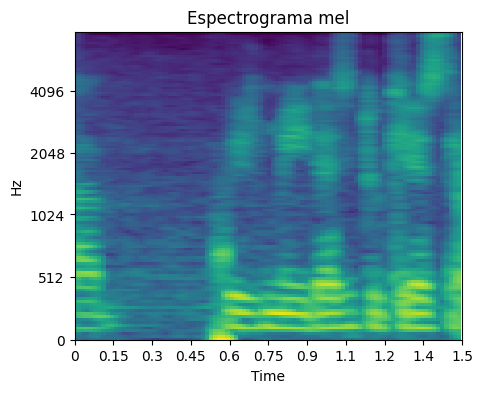

In [ ]:
nombre = 'audio01_referencia.wav'
audio = segmentos_test[nombre][2]
fs = audios_test[nombre]['fs']
Audio(audio,rate=fs)
make_spectrograms_all_scales(segm=audio, fs=fs, NFFT=2048, sample_hop=256, scales=['mel'], pathFile='espectrograma_lineal.pdf', ylimmin=0, ylimmax=8000, xlimmin=0, xlimmax=1.5)

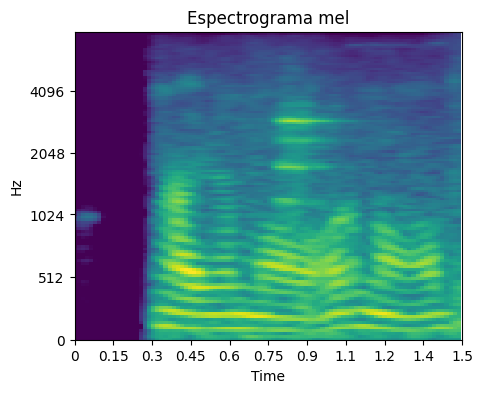

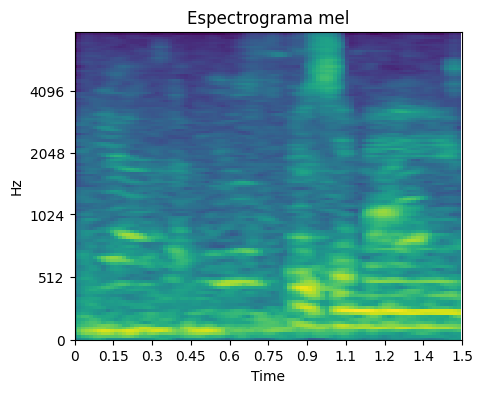

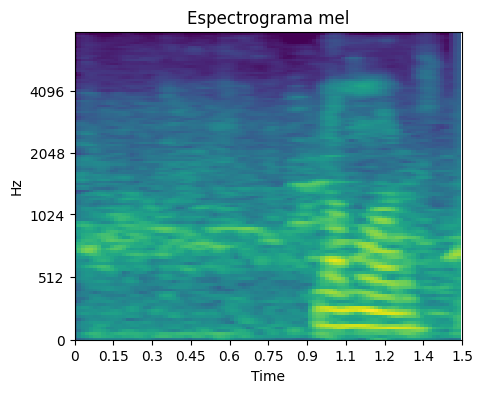

In [ ]:
nombre = 'audio02_balcon.wav'
audio = segmentos_test[nombre][0]
fs = audios_test[nombre]['fs']
Audio(audio,rate=fs)
make_spectrograms_all_scales(segm=audio, fs=fs, NFFT=2048, sample_hop=256, scales=['mel'], pathFile='espectrograma_lineal.pdf', ylimmin=0, ylimmax=8000, xlimmin=0, xlimmax=1.5)

nombre = 'audio03_calle.wav'
audio = segmentos_test[nombre][0]
fs = audios_test[nombre]['fs']
Audio(audio,rate=fs)
make_spectrograms_all_scales(segm=audio, fs=fs, NFFT=2048, sample_hop=256, scales=['mel'], pathFile='espectrograma_lineal.pdf', ylimmin=0, ylimmax=8000, xlimmin=0, xlimmax=1.5)

nombre = 'audio04_universidad.wav'
audio = segmentos_test[nombre][0]
fs = audios_test[nombre]['fs']
Audio(audio,rate=fs)
make_spectrograms_all_scales(segm=audio, fs=fs, NFFT=2048, sample_hop=256, scales=['mel'], pathFile='espectrograma_lineal.pdf', ylimmin=0, ylimmax=8000, xlimmin=0, xlimmax=1.5)

###### **Impostores Vs Referencia**

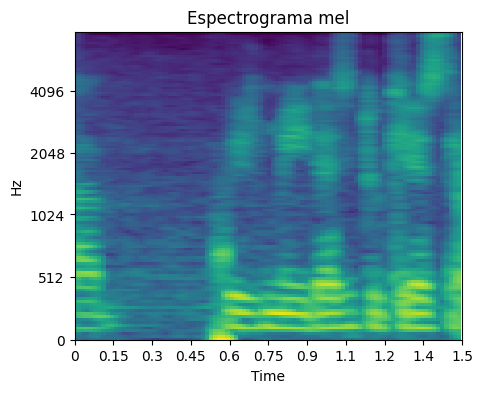

In [ ]:
nombre = 'audio01_referencia.wav'
audio = segmentos_test[nombre][2]
fs = audios_test[nombre]['fs']
Audio(audio,rate=fs)
make_spectrograms_all_scales(segm=audio, fs=fs, NFFT=2048, sample_hop=256, scales=['mel'], pathFile='espectrograma_lineal.pdf', ylimmin=0, ylimmax=8000, xlimmin=0, xlimmax=1.5)

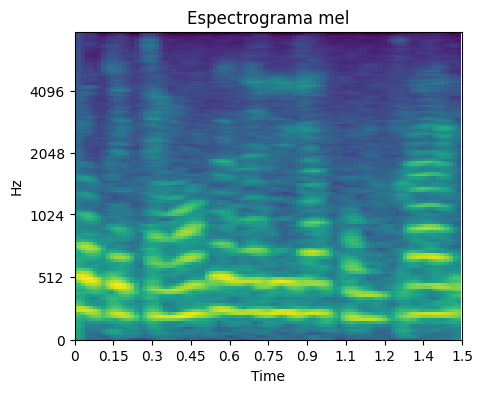

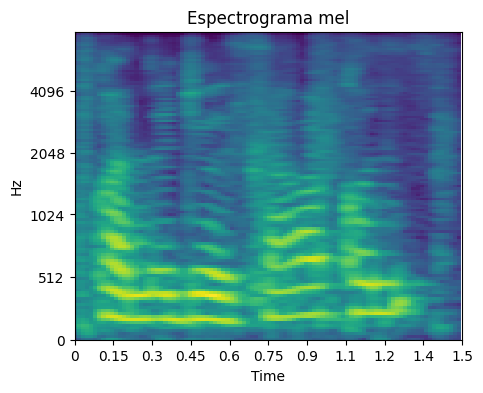

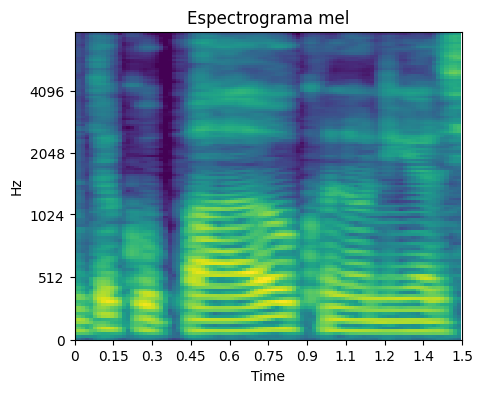

In [ ]:
nombre = 'W_19_audio09.wav'
audio = segmentos_impostores[nombre][1]
fs = audios_impostores[nombre]['fs']
Audio(audio,rate=fs)
make_spectrograms_all_scales(segm=audio, fs=fs, NFFT=2048, sample_hop=256, scales=['mel'], pathFile='espectrograma_lineal.pdf', ylimmin=0, ylimmax=8000, xlimmin=0, xlimmax=1.5)

nombre = 'W_22_audio10.wav'
audio = segmentos_impostores[nombre][3]
fs = audios_impostores[nombre]['fs']
Audio(audio,rate=fs)
make_spectrograms_all_scales(segm=audio, fs=fs, NFFT=2048, sample_hop=256, scales=['mel'], pathFile='espectrograma_lineal.pdf', ylimmin=0, ylimmax=8000, xlimmin=0, xlimmax=1.5)

nombre = 'M_21_audio02.wav'
audio = segmentos_impostores[nombre][3]
fs = audios_impostores[nombre]['fs']
Audio(audio,rate=fs)
make_spectrograms_all_scales(segm=audio, fs=fs, NFFT=2048, sample_hop=256, scales=['mel'], pathFile='espectrograma_lineal.pdf', ylimmin=0, ylimmax=8000, xlimmin=0, xlimmax=1.5)

####**Extracción de características**

**Representación mediante MFCCs:** Se utilizó la función librosa.feature.mfcc, que internamente aplica un banco de filtros Mel sobre el espectrograma del audio. Aunque el banco Mel no se construyó explícitamente, el proceso lo incorpora de forma automática, por lo tanto se cumple con la restricción de basar la solución en un banco de filtros.

**n_mels = 128:** aumenta la resolución del banco de filtros Mel, permitiendo capturar diferencias más finas en la estructura espectral de la voz, como los formantes y la distribución de energía.

**n_fft = 1024:** mejora la resolución frecuencial, permitiendo distinguir con mayor claridad los armónicos y matices propios de cada locutor.

**hop_length ≈ 512:** establece un espaciado temporal entre ventanas que ofrece un buen equilibrio entre detalle temporal y estabilidad del espectro (solape del 50%).

Se hicieron pruebas con diferentes parámetros como los coeficientes MFCCs como por ejemplo 13 (uno muy usado segun la literatura), el orden del banco de filtros mel con 40 y 26, tambien muy usado, con NFFT de 512 y 2048, con diferentes tamaños de solape, y esta configuracion de forma experimental fue la que mas se ajustó, sobre todo porque en la base de datos hay muchos impostores que hablan muy similar a a la voz a identificar debido a la edad y entorno.

Delta y Delta-Delta: se calcularon las derivadas de primer y segundo orden de los coeficientes MFCC, lo cual permitió capturar la dinámica temporal de la señal.

Resumen estadístico: por cada segmento se calcularon la media y desviación estándar de los 26 MFCCs y sus derivadas, generando un vector de 156 características por segmento. `26 MFFCs por 3 ya que tuvimos en cuenta las derivadas y por 2 ya que sacamos media y varianza`.

Selección de segmentos relevantes: para evitar el ruido o pausas, se extrajeron los tres segmentos más energéticos por audio. Los vectores de estos tres bloques se promediaron para construir una representación final por audio.

In [ ]:
def extraer_vector_mfcc_deltas(segmento, fs=16000, n_mfcc=26):
    """
    Extrae un vector de características a partir de un segmento de audio usando MFCCs
    y sus derivadas (deltas y delta-deltas), junto con estadísticas básicas.

    El vector final tiene 156 dimensiones (media y std de MFCCs, delta, y delta-delta).

    Parámetros:
    - segmento: np.array
        Señal de audio mono.
    - fs: int
        Frecuencia de muestreo (default: 16000 Hz).
    - n_mfcc: int
        Número de coeficientes MFCC a calcular. Por defecto: 26.

    Retorna:
    - np.array (156,)
        Vector de características del segmento.
    """
    segmento = segmento.astype(np.float32)
    mfcc = librosa.feature.mfcc(y=segmento, sr=fs, n_mfcc=n_mfcc, n_mels=128, n_fft=1024, hop_length=512) #Calcula los coeficientes MFCC
    delta = librosa.feature.delta(mfcc) #Calcula la derivada temporal
    delta2 = librosa.feature.delta(mfcc, order=2) #Calcula la seguda derivada temporal
    full = np.vstack([mfcc, delta, delta2]) #los une todas en una sola matriz
    media = np.mean(full, axis=1) #calcula el promedio de las 78 caracteristicas a lo largo del tiempo
    std = np.std(full, axis=1) #Lo nisno pero con la desviacion estandar
    return np.concatenate([media, std]) #une los estadisticos a la matriz



In [ ]:
def energia_segmento(segmento):
    """
    Calcula la energía promedio de un segmento de audio.

    Parámetros:
    - segmento: np.array
        Array unidimensional que representa una señal de audio (amplitud en el tiempo).

    Retorna:
    - float
        Energía promedio del segmento, definida como el valor medio de la señal al cuadrado.
    """
    return np.mean(segmento**2)


In [ ]:
def vector_por_audio_top_segmentos(segmentos, top_n=3):
    """
    Genera un vector representativo para un audio a partir de sus segmentos más energéticos.

    Parámetros:
    - segmentos: list of np.array
        Lista de segmentos de audio.
    - top_n: int
        Número de segmentos con mayor energía a considerar (default: 3).

    Retorna:
    - np.array (156,)
        Vector promedio representativo del audio.
    """
    energias = [energia_segmento(seg) for seg in segmentos] #calcula la energia promedio de cada segmento
    idx_ordenados = np.argsort(energias)[::-1][:top_n] #Ordena los índices de los segmentos de mayor a menor energía
    vectores = [extraer_vector_mfcc_deltas(segmentos[i]) for i in idx_ordenados] #aplicamos la matriz a los 3 mejores segmentos (mas energeticos)
    return np.mean(np.vstack(vectores), axis=0) #Realizamos el promedio por banda de frecuencia, generando un unico vector representativo



In [ ]:
def generar_vectores_top_segmentos(segmentos_por_audio, top_n=3):
    """
    Genera vectores representativos para una colección de audios segmentados,
    utilizando los 'top_n' segmentos más energéticos de cada uno.

    Parámetros:
    - segmentos_por_audio: dict
        Diccionario {nombre_audio: [segmento1, segmento2, ...]}
    - top_n: int
        Número de segmentos más energéticos a considerar por audio (default: 3).

    Retorna:
    - dict
        Diccionario {nombre_audio: vector_representativo (np.array de 156)}
    """
    vectores = {} #diccionario donde se guardara cada vector representativo ppor audi0
    for nombre, segmentos in segmentos_por_audio.items():
        vector = vector_por_audio_top_segmentos(segmentos, top_n=top_n) #generamos el vector representativo
        vectores[nombre] = vector #llenamos diccionario
    return vectores

In [ ]:
vectores_test_top = generar_vectores_top_segmentos(segmentos_test)
vectores_impostores_top = generar_vectores_top_segmentos(segmentos_impostores)


##**Análisis de similitud**

Se calculó la distancia coseno para cada audio de test y el audio de referencia y para cada audio de impostores y el audio de referencia

Estas distancias se visualizaron en forma de histogramas y en un print para visualizar de uan forma numerica mas clara. Se evaluaron múltiples audios como posibles referencias, seleccionando finalmente aquel cuya voz era más clara, sin ruido, y con buena proyección vocal.

Con esta selección y refinamiento de vectores, se observó que la gran mayoría de las distancias del conjunto de test caían por debajo del umbral de 0.96, mientras que las de los impostores eran notablemente mayores.

In [ ]:
X_total = list(vectores_test_top.values()) + list(vectores_impostores_top.values()) #Unimos los vectores en una sola lista
X_matrix = np.vstack(X_total) #los unimos a una matriz donde cada fila es un vector
scaler = StandardScaler() #objeto de normalizacion que estandariza los vectores a media=0 y desviacion a 1
X_norm = scaler.fit_transform(X_matrix) #aplicamos la normalizacion
n_test = len(vectores_test_top) #calculamos llos vectores de test para separar la matriz y dejarlo en vectores normalizados ppor aparte (reconstruir diccionario)
X_test = X_norm[:n_test] #separa las filas de test
X_impostores = X_norm[n_test:] #separa las filas de impostores
vectores_test_norm = dict(zip(vectores_test_top.keys(), X_test))  #reconstruimos los diccionarios
vectores_impostores_norm = dict(zip(vectores_impostores_top.keys(), X_impostores))

NameError: name 'vectores_test_top' is not defined

In [ ]:
nombre_ref = 'audio01_referencia.wav'
vector_ref = vectores_test_norm[nombre_ref]

print(f"Comparando con referencia: {nombre_ref}\n")

print("Test vs Referencia:")
for nombre, vector in vectores_test_norm.items():
    if nombre == nombre_ref: #no calcular distancia coseno con el mismo
        continue
    dist = cosine(vector_ref, vector) #calculamos distancia coseno
    print(f"{nombre:<30} d_coseno = {dist:.4f}")

print("\nImpostores vs Referencia:")
for nombre, vector in vectores_impostores_norm.items():
    dist = cosine(vector_ref, vector) #calculamos distancia coseno
    print(f"{nombre:<30} d_coseno = {dist:.4f}")

NameError: name 'vectores_test_norm' is not defined

##**Regla de decisión**


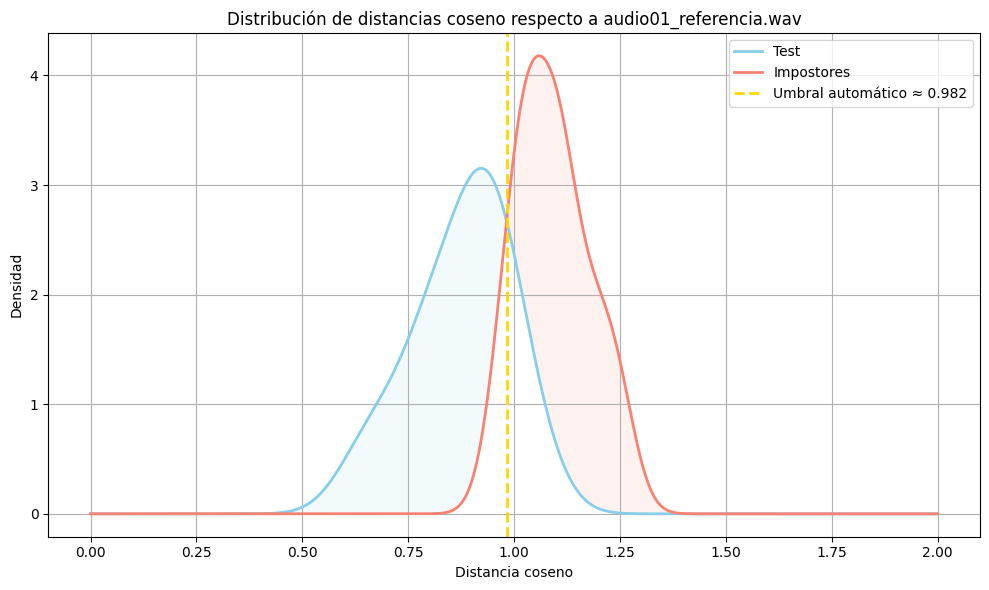

Umbral automático (intersección de KDEs): 0.9822
Accuracy alcanzada: 93.33%

Test:
Test aceptados  (TP): 9
Test rechazados (FN): 1

Impostores:
Impostores rechazados (TN): 19
Impostores aceptados  (FP): 1


In [ ]:
distancias_test = [cosine(vector_ref, v) for nombre, v in vectores_test_norm.items() if nombre != nombre_ref] #guaradmos en una lista cada distancia coseno excluyendo la de referencia
distancias_impostores = [cosine(vector_ref, v) for v in vectores_impostores_norm.values()] #hacemos lo mismo

y_true = [1] * len(distancias_test) + [0] * len(distancias_impostores)#Esta línea construye la lista concatenando
                                                                      #una lista de 1s del mismo tamaño que la cantidad de distancias de test
                                                                      #con una lista de 0s del mismo tamaño que la cantidad de distancias de impostores

kde_test = gaussian_kde(distancias_test) #generamos densidad de probabilidad
kde_impostores = gaussian_kde(distancias_impostores)

xs = np.linspace(0, 2, 1000) #rango para evaluar distribuciones
pdf_test = kde_test(xs)
pdf_impostores = kde_impostores(xs) #las evakuamos en el rango definido

def diferencia(x): return kde_test(x) - kde_impostores(x) #funcion quue representa la diferencia entre ambas curvas

umbral= brentq(diferencia, 0.8, 1.1) #busca el punto donde esa disancia es minima (intersección)

y_pred = [1 if d <= umbral else 0 for d in distancias_test] + [1 if d <= umbral else 0 for d in distancias_impostores] #definimos cuando se toma que se predijo bien y cuando mal

cm = confusion_matrix(y_true, y_pred) #Calcula la matriz de confusión comparando las etiquetas reales (y_true)
                                      #con las predicciones realizadas (y_pred)
tn, fp, fn, tp = cm.ravel() #Aplana la matriz de 2x2 obteniendo asi un vector con tn, fp..etc
accuracy = accuracy_score(y_true, y_pred) #accuracy = (# de aciertos) / (total de casos) = sum(y_true[i] == y_pred[i]) / len(y_true)

plt.figure(figsize=(10, 6))
plt.plot(xs, pdf_test, label='Test', color='skyblue', linewidth=2)
plt.plot(xs, pdf_impostores, label='Impostores', color='salmon', linewidth=2)
plt.axvline(umbral, color='gold', linestyle='--', linewidth=2, label=f'Umbral automático ≈ {umbral:.3f}')

plt.fill_between(xs, pdf_test, pdf_impostores, where=(pdf_test > pdf_impostores), color='skyblue', alpha=0.1)
plt.fill_between(xs, pdf_impostores, pdf_test, where=(pdf_impostores > pdf_test), color='salmon', alpha=0.1)
plt.title(f"Distribución de distancias coseno respecto a {nombre_ref}")
plt.xlabel("Distancia coseno")
plt.ylabel("Densidad")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Umbral automático (intersección de KDEs): {umbral:.4f}")
print(f"Accuracy alcanzada: {accuracy:.2%}\n")
print("Test:")
print(f"Test aceptados  (TP): {tp}")
print(f"Test rechazados (FN): {fn}\n")
print("Impostores:")
print(f"Impostores rechazados (TN): {tn}")
print(f"Impostores aceptados  (FP): {fp}")




##**Tabla de problemas y correcciones aplicadas**

| Problema identificado                      | Corrección aplicada                                               |
|--------------------------------------------|-------------------------------------------------------------------|
| Segmentos de silencio o ruidos prolongados | Aumento de duración de segmento de 1s → 1.5s                        |
| Amplitudes variables entre audios          | Normalización de señal a [-1, 1]                                  |
| Variabilidad por estéreo                   | Conversión a mono                                                 |
| Frecuencia innecesariamente alta           | Remuestreo a 16 kHz                                               |
| Segmentos con poco contenido vocal         | Selección por energía promedio (top-3 segmentos)                  |
| Métrica sensible a magnitud, no dirección  | Uso de **distancia coseno** y **Pearson** como métricas          |
| Variabilidad en escala entre vectores      | Aplicación de `StandardScaler` a todos los vectores              |
| Test dispersos en el espacio vectorial     | Cambio del audio de referencia a uno más estable y claro         |
| Test e impostores solapados en distancias  | Ajuste del vector de características y selección de segmentos    |


## **Análisis de herramientas y funciones utilizadas**

En esta sección se explican las funciones y métricas más importantes utilizadas en el desarrollo del sistema de reconocimiento de voz. El objetivo es comprender qué hace cada componente y por qué es relevante para el sistema.

### 1. MFCCs (`librosa.feature.mfcc`)

- Extraen características acústicas que representan cómo suena una voz humana.
- Se basan en la percepción auditiva humana (escala Mel).
- Proceso:
  1. Divide el audio en ventanas.
  2. Calcula la energía en bandas de frecuencia perceptuales (filtros Mel).
  3. Aplica la Transformada Discreta del Coseno (DCT) para compactar la información.

**Resultado:** Una representación compacta de las características espectrales de la voz.

### 2. Derivadas temporales (`librosa.feature.delta`)

- Calculan cómo varían los MFCCs a lo largo del tiempo.
- Se calculan:
  - `delta`: primera derivada (velocidad).
  - `delta-delta`: segunda derivada (aceleración).
  
**Resultado:** Añade información dinámica que mejora la discriminación entre voces.

### 3. Distancia coseno (`scipy.spatial.distance.cosine`)

- Mide el ángulo entre dos vectores.
- No se ve afectada por la magnitud (solo por la dirección).

$$
\text{Distancia coseno} = 1 - \frac{\vec{A} \cdot \vec{B}}{\|\vec{A}\| \cdot \|\vec{B}\|}
$$


**Resultado:** Útil para comparar vectores de características de diferentes voces.

### 4. `StandardScaler` (`sklearn.preprocessing`)

- Normaliza los vectores para que cada característica tenga:
  - Media 0
  - Desviación estándar 1

$$
x' = \frac{x - \mu}{\sigma}
$$

**Resultado:** Mejora la comparación entre vectores y evita que características con mayor escala dominen la similitud.

### 5. `accuracy_score` (`sklearn.metrics`)

- Calcula la proporción de predicciones correctas.

$$
\text{Accuracy} = \frac{\text{Aciertos}}{\text{Total de muestras}}
$$

**Resultado:** Métrica principal para evaluar el rendimiento del sistema.

### 7. Matriz de confusión (`confusion_matrix`)

Muestra la relación entre predicciones y realidad:

|                 | Predicho: 0 | Predicho: 1 |
|-----------------|-------------|-------------|
| Real: 0 (impostor) | TN          | FP          |
| Real: 1 (test)      | FN          | TP          |

**Resultado:** Permite identificar errores tipo I (FP) y tipo II (FN).

### 8. KDE - Estimación de densidad (Gaussian KDE)

- Genera curvas suavizadas que representan la distribución de distancias coseno.
- Cada punto se trata como una "campana" Gaussiana y se suman todas.

**Resultado:** Visualización continua y suave de la distribución de distancias.

### 9. Umbral automático (`brentq` de `scipy.optimize`)

- Encuentra el punto de intersección entre las curvas de densidad de test e impostores.
- Método: bisección y interpolación (Brent's method).
- Requiere que la diferencia entre curvas cambie de signo en el intervalo.

**Resultado:** Umbral óptimo para separar ambas clases.

### 10. Promedio y ordenamiento (`np.mean`, `np.argsort`)

- `np.mean`: Promedia vectores para obtener representaciones estables.
- `np.argsort`: Ordena índices según un criterio (por ejemplo, energía).


##**Función de Reconocimiento de Voz**

###**Funciones auxiliares**

In [ ]:
#Como la logica para generar el modelo y verificarlo fue con diccionarios, se vio en la necesidad de crear estas dos funciónes aparte
def segmentar_audio_unico(audio, fs, dur_segmento):
    """
    Segmenta un único audio en partes de duración fija.

    Retorna:
    - lista de segmentos
    """
    muestras_por_segmento = int(fs * dur_segmento)
    total_muestras = len(audio)
    segmentos = []
    for i in range(0, total_muestras - muestras_por_segmento + 1, muestras_por_segmento):
        segmento = audio[i:i + muestras_por_segmento]
        segmentos.append(segmento)
    return segmentos

def preprocesar_audio(audio_path, fs_target=16000):
    """
    Carga, convierte a mono, normaliza y remuestrea un archivo de audio.

    Parámetros:
    - audio_path: str
        Ruta del archivo .wav
    - fs_target: int
        Frecuencia de muestreo deseada (default: 16000 Hz)

    Retorna:
    - audio: np.array
        Señal procesada (mono, normalizada, remuestreada)
    - fs: int
        Frecuencia de muestreo final (fs_target)
    """
    fs, audio = read(audio_path)
    if len(audio.shape) > 1:
        audio = audio.mean(axis=1)
    if np.max(np.abs(audio)) > 0:
        audio = audio / np.max(np.abs(audio))
    audio = audio.astype(np.float32)
    if fs != fs_target:
        audio = librosa.resample(audio, orig_sr=fs, target_sr=fs_target)
        fs = fs_target

    return audio, fs


###**Funición principal**

In [ ]:
def reconocimiento_de_voz(audio_path, vector_ref, umbral, scaler, dur_segmento=1.5, top_n=3, fs_target=16000):
    """
    Determina si un audio corresponde a la voz de referencia,
    usando extracción de MFCCs con deltas, y distancia coseno.

    Parámetros:
    - audio_path: str
        Ruta local del archivo .wav a verificar.
    - vector_ref: np.array
        Vector representativo de referencia (normalizado).
    - umbral: float
        Umbral de decisión (valor de corte en la distancia).
    - scaler: StandardScaler
        Escalador entrenado con los vectores originales (para normalizar).
    - dur_segmento: float
        Duración (en segundos) de los segmentos a procesar (default: 1.5s).
    - top_n: int
        Número de segmentos más energéticos a usar (default: 3).
    - fs_target: int
        Frecuencia de muestreo deseada (default: 16000 Hz).

    Retorna:
    - resultado: str
        "Es mi voz" o "No soy yo"
    """

    #Preprocesamiento del audio: carga, mono, normalización, remuestreo
    audio, fs = preprocesar_audio(audio_path, fs_target=fs_target)

    #Segmentación
    segmentos = segmentar_audio_unico(audio, fs, dur_segmento)

    #Extracción de vector representativo usando MFCCs + deltas + media + std
    vector = vector_por_audio_top_segmentos(segmentos, top_n)

    #Normalizar el vector con el mismo scaler usado para la base
    vector_norm = scaler.transform([vector])[0]

    #Calcular distancia coseno respecto al vector de referencia
    distancia = cosine(vector_norm, vector_ref)

    #Clasificación final basada en el umbral
    resultado = "Es mi voz" if distancia <= umbral else "No soy yo"

    return resultado

In [ ]:
reconocimiento_de_voz("pruebas.wav", vector_ref, umbral, scaler)

NameError: name 'vector_ref' is not defined